In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import statsmodels.api as sm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<h3>Retrieve and load data</h3>

In [3]:
!curl -O https://github.com/fedhere/PUI2017_fb55/blob/master/HW10_fb55/MTA_Fare.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32015    0 32015    0     0  32015      0 --:--:-- --:--:-- --:--:--  134k


In [9]:
!wget -O MTA_Fare.npy https://github.com/fedhere/PUI2017_fb55/blob/master/HW10_fb55/MTA_Fare.npy?raw=true

--2017-12-03 23:28:28--  https://github.com/fedhere/PUI2017_fb55/blob/master/HW10_fb55/MTA_Fare.npy?raw=true
Resolving github.com... 192.30.253.113, 192.30.253.112
Connecting to github.com|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/fedhere/PUI2017_fb55/raw/master/HW10_fb55/MTA_Fare.npy [following]
--2017-12-03 23:28:28--  https://github.com/fedhere/PUI2017_fb55/raw/master/HW10_fb55/MTA_Fare.npy
Connecting to github.com|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW10_fb55/MTA_Fare.npy [following]
--2017-12-03 23:28:28--  https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW10_fb55/MTA_Fare.npy
Resolving raw.githubusercontent.com... 151.101.20.133
Connecting to raw.githubusercontent.com|151.101.20.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10708880 (10M) [applica

In [10]:
mta = np.load('MTA_Fare.npy')

In [11]:
mta.shape

(600, 23, 194)

In [12]:
# Replace -1 with NaN
mta = mta.astype('float')
mta [mta == -1] = np.nan

<h3>Task 1</h3>

In [13]:
# Sum array across arrays to get total ridership by week
all_sum = np.nansum(np.nansum(mta, axis=0),axis=0)

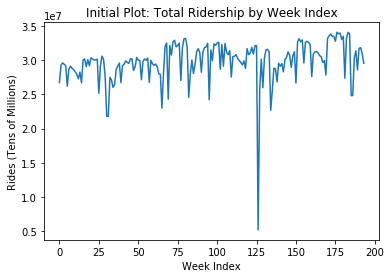

In [14]:
# Initial plot
plt.plot(all_sum)
plt.xlabel('Week Index')
plt.ylabel('Rides (Tens of Millions)')
plt.title('Initial Plot: Total Ridership by Week Index')

<b>Figure 1</b>: Initial plot of ridership across all axes. Very obvious outlier around index 125. Below we will match it to a date and investigate.

In [15]:
# Per the homework notes, data spans 05/21/2010 to 02/21/2014, which is 197 weeks but only 194 weeks in the data
# Actual dates may vary slightly, accordingly
date_axis = pd.date_range('5/21/2010', periods=194, freq='W-FRI')

In [16]:
print("Mean weekly ridership: {:,}".format(int(all_sum.mean())))
print("Std. dev weekly ridership: {:,}".format(int(all_sum.std())))

Mean weekly ridership: 29,781,349
Std. dev weekly ridership: 2,983,960


In [17]:
min_val = all_sum.min()
min_z_score = (min_val - all_sum.mean()) / all_sum.std()

print("Lowest weekly ridership: {:,}".format(min_val))
print("Lowest ridership z-score: {:.2f}".format(min_z_score))

Lowest weekly ridership: 5,218,686.0
Lowest ridership z-score: -8.23


In [18]:
# Get index of low point and match to date
wk_index = np.where(all_sum == all_sum.min())
date_axis[wk_index]

DatetimeIndex(['2012-10-19'], dtype='datetime64[ns]', freq=None)

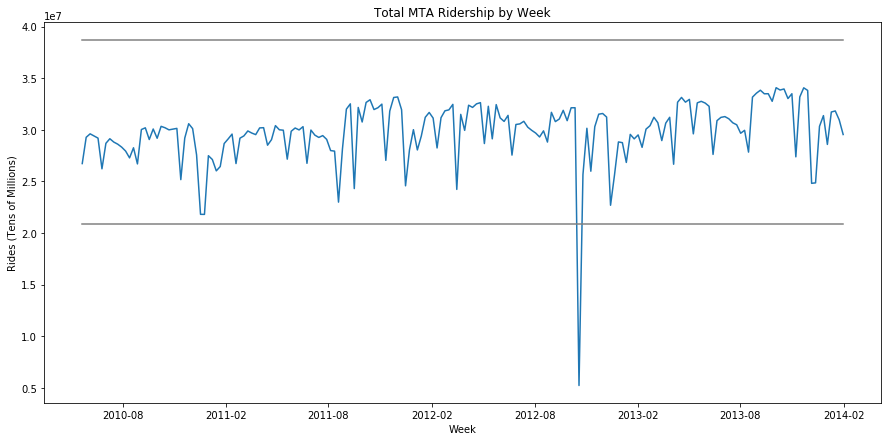

In [19]:
plt.figure(figsize=(15,7))
plt.plot(date_axis,all_sum)
plt.plot(date_axis,[all_sum.mean() - 3 * all_sum.std()] * 194, color='gray') # +3 sigma
plt.plot(date_axis,[all_sum.mean() + 3 * all_sum.std()] * 194, color='gray') # -3 sigma
plt.xlabel('Week')
plt.ylabel('Rides (Tens of Millions)')
plt.title('Total MTA Ridership by Week')

<b>Figure 2</b>: Better view of ridership across all axes. Lowest point corresponds to mid-to-late October 2012. Lines for +- 3-sigma thresholds.

The event is Hurricane Sandy. News headline from that period:
<br>
![News](NewsScreenshot.PNG)

Makes sense!

<h3>Task 2</h3>

In [20]:
# Federica's ride type array
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [22]:
# Sum array across stations to get total ridership by type by week
type_sum = np.nansum(mta, axis=0)
type_sum.shape

(23, 194)

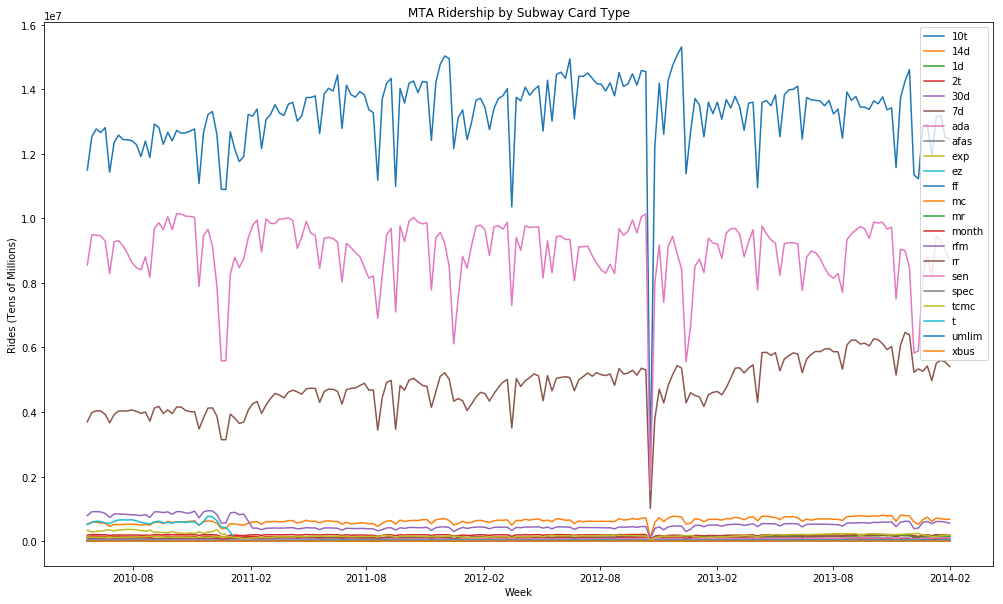

In [23]:
# Plot ridership for each card type
plt.figure(figsize=(17,10))

for elem in range(0,22):
    plt.plot(date_axis, type_sum[elem])
    
plt.title('MTA Ridership by Subway Card Type')
plt.xlabel('Week')
plt.ylabel('Rides (Tens of Millions)')
plt.legend(ridetype)

<b>Figure 3</b>: Weekly MTA ridership by each of 23 rider card types. A few card types dominate and obscure the visibility of the other card types. Below, will use log y-axis to distinguish card types better.

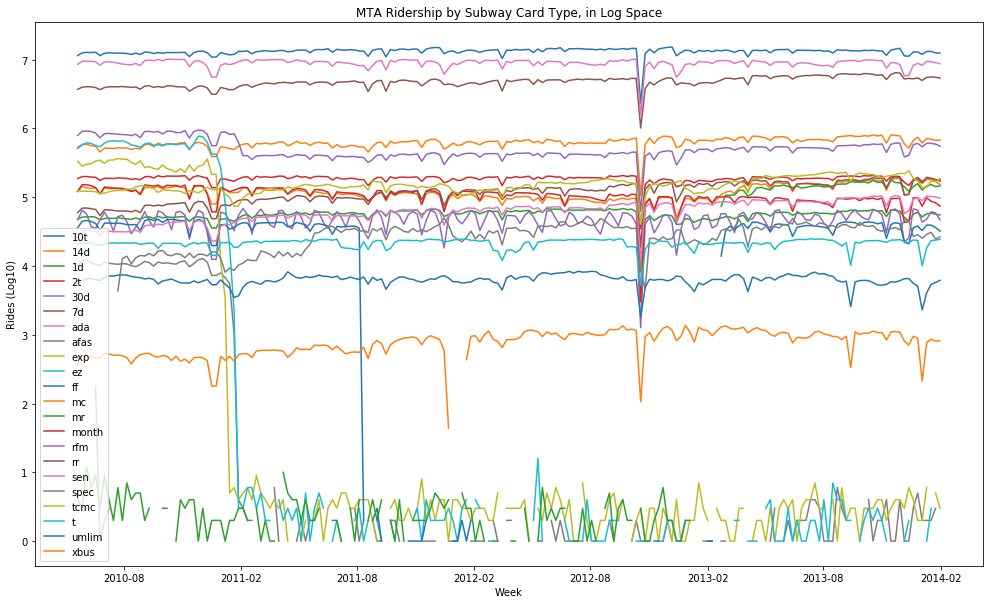

In [25]:
# Again, with log y-axis
plt.figure(figsize=(17,10))
for elem in range(0,22):
    plt.plot(date_axis, np.log10(type_sum[elem]))
plt.title('MTA Ridership by Subway Card Type, in Log Space')
plt.xlabel('Week')
plt.ylabel('Rides (Log10)')
plt.legend(ridetype)

<b>Figure 4</b>: Weekly MTA ridership by each of 23 rider card types in log space. Easier to see patterns in each card type but log axis suppresses the overall trend.

In [26]:
# Perform stationarity test (AD Fuller) on each ridership type trend
# Higher test score p-values correspond to less stationarity
print("AD-Fuller p-value by ride card type\n")
for elem in range(len(ridetype)):
    print(ridetype[elem] + ": " + " " * (6 - len(ridetype[elem])) + \
          "{:.2f}".format(sm.tsa.adfuller(type_sum[elem])[1])) # Pretty print

AD-Fuller p-value by ride card type

10t:    0.00
14d:    0.22
1d:     0.23
2t:     0.00
30d:    0.00
7d:     0.53
ada:    0.00
afas:   0.09
exp:    0.03
ez:     0.12
ff:     0.54
mc:     0.87
mr:     0.93
month:  0.55
rfm:    0.23
rr:     0.76
sen:    0.74
spec:   0.07
tcmc:   0.04
t:      0.00
umlim:  0.00
xbus:   0.38
stud:   0.05


In [27]:
# Ridership ratios of first 5 vs. last 5 weeks
for elem in range(len(ridetype)):
    ride_ratio = np.average(type_sum[elem][-5:]) / np.average(type_sum[elem][0:5])
    print(ridetype[elem] + ": " + " " * (6 - len(ridetype[elem])) + " {:>10.3f}".format(ride_ratio))

10t:          1.016
14d:          1.199
1d:           1.099
2t:           0.924
30d:          1.074
7d:           1.375
ada:          0.967
afas:         0.000
exp:          0.000
ez:           0.000
ff:           0.847
mc:           1.256
mr:       20973.294
month:        0.585
rfm:          0.663
rr:           2.693
sen:          3.133
spec:       774.051
tcmc:         1.318
t:            0.942
umlim:        0.749
xbus:         1.557
stud:           inf


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


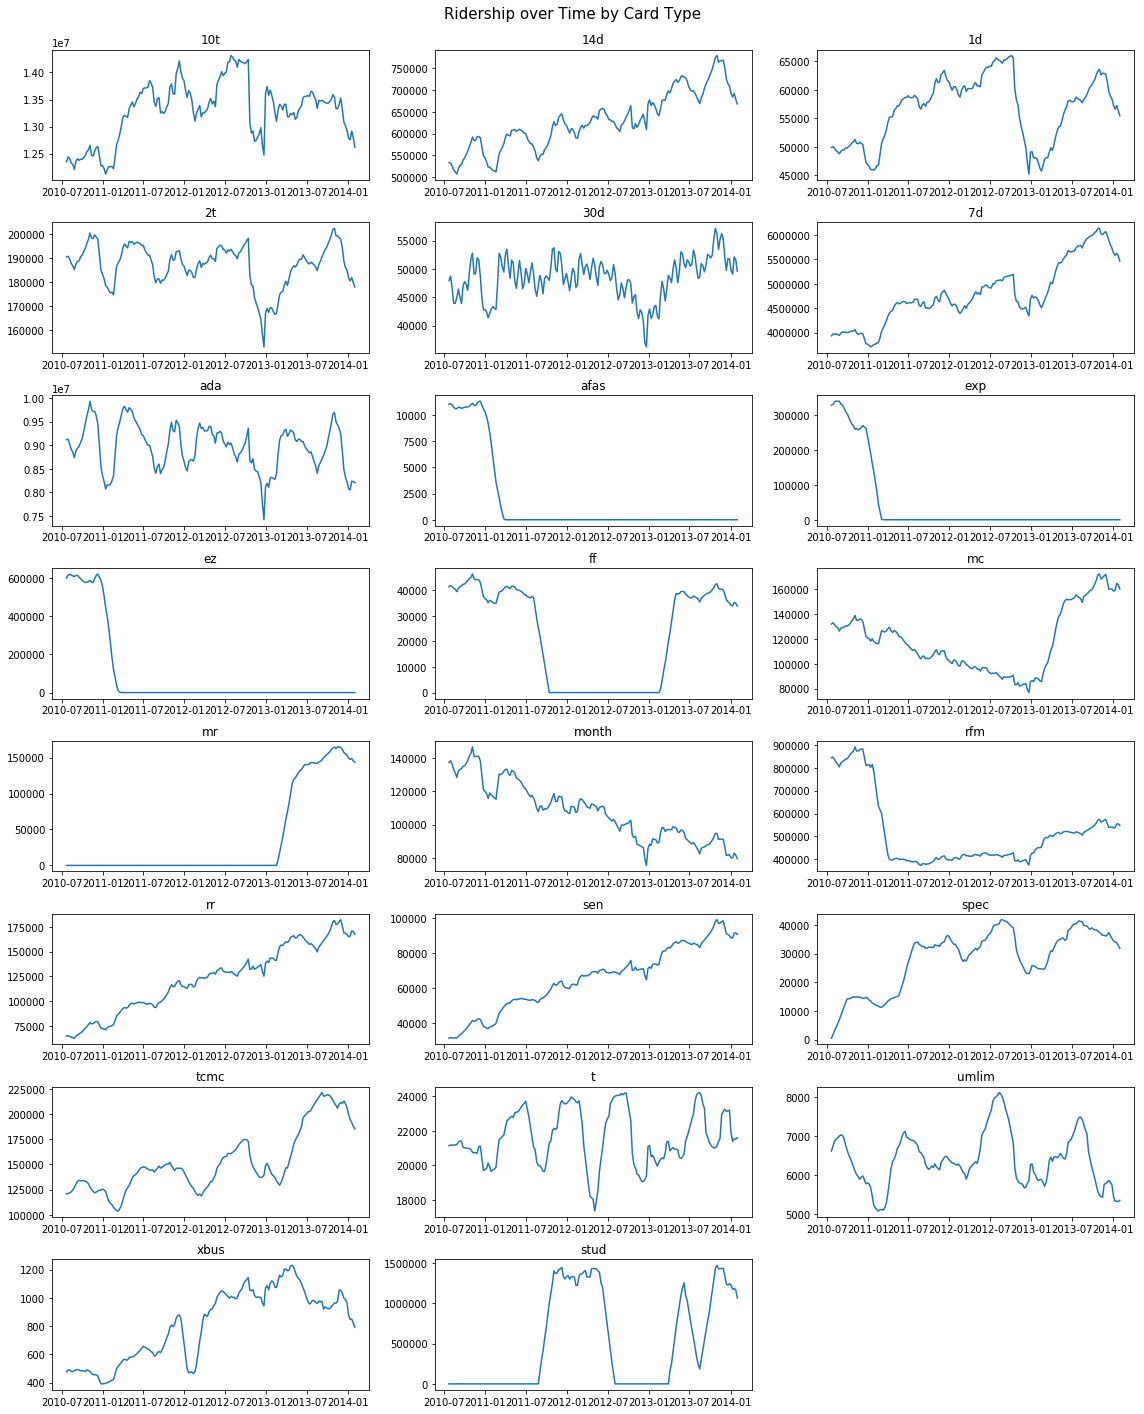

In [28]:
# Plot trend for each rider card type
fig = plt.figure(figsize=(16,20))
fig.suptitle("Ridership over Time by Card Type", fontsize=15)

for elem in range(len(ridetype)):
    ax = fig.add_subplot(8, 3, elem + 1)
    plt.plot(date_axis, pd.rolling_mean(type_sum[elem],10))
    plt.title(ridetype[elem])
    
fig.tight_layout()
fig.subplots_adjust(top=0.95)

<b>Figure 5</b>: Small multiples of ridership over time period for each of the 23 card types. Below, a visual inspection of the results, aided by the AD test and the ratios, will inform the identification of steadily increasing/decreasing card types.

Steadily increasing ride cards are:<br><br>
    <b>Card (AD p-value, change ratio)</b><br>
    14d (0.22, 1.199)<br>
    7d (0.53, 1.375)<br>
    rr (0.76, 2.693)<br>
    sen (0.74, 3.133)<br><br>
Several others (tcmc, xbus, spec) show some overall increase but at a more erratic rate.
<br><br>
Steadily decreasing:<br><br>
month (0.55, 0.585)

<h3>Task 3</h3>

In [29]:
# Sum array across ride cards to get total ridership by station by week
stat_sum = np.nansum(mta, axis=1)
stat_sum = stat_sum.astype(int)
stat_sum.shape

(600, 194)

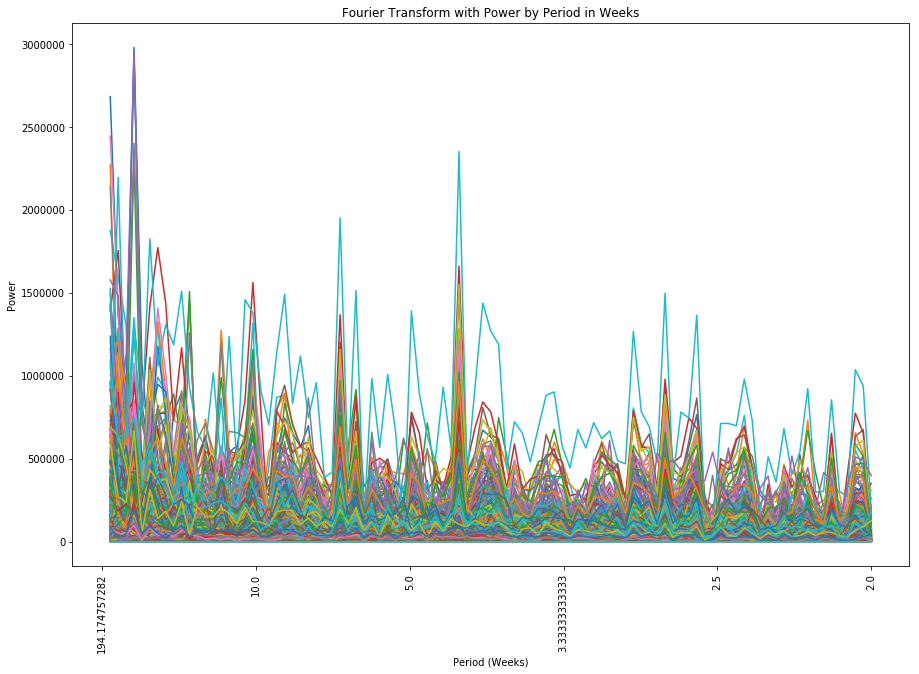

In [33]:
# Plot each station's Fourier transform 

fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)

# Hacky way to get tick labels below
ticks2 = [100, 0.00515, 0.1, 0.2, 0.3, 0.4, 0.5]

for elem in range(len(stat_sum)):

    fft_result = np.abs(np.fft.rfft(stat_sum[elem]))[1:] # Ignore first value

    freq_axis = np.fft.rfftfreq(194,1)[1:] 

    plt.plot(freq_axis, fft_result)
    #ax.plot(x, f)

ax.set_xticklabels(["%s"%(1/f) for f in ticks2], rotation=90)
ax.set_xlabel('Period (Weeks)')
ax.set_ylabel('Power')
ax.set_title('Fourier Transform with Power by Period in Weeks')

<b>Figure 6</b>: Fourier transform results for all 600 stations with period in weeks and power. We'll identify below the top 4 stations by power around the 52-week mark.

In [35]:
# Create dictionary for each station and its 52-week power value
stat_power = {}
for elem in range(len(stat_sum)):
    stat_power[elem] = np.abs(np.fft.rfft(stat_sum[elem]))[4] # Slicing for 52-week (approx.) value

In [39]:
# Sort and print top 4 stations from dictionary above
top_list = []
print("Top 4 Stations by Power at 52-week Period")
for key, value in sorted(stat_power.iteritems(), key=lambda (k,v): (v,k), reverse=True)[:4]:
    print "%s: %s" % (key, value) # Source: https://www.saltycrane.com/blog/2007/09/how-to-sort-python-dictionary-by-keys/
    top_list.append(key)

Top 4 Stations by Power at 52-week Period
0: 2980160.6356
194: 2950388.92921
150: 2931895.87695
327: 2402218.58096


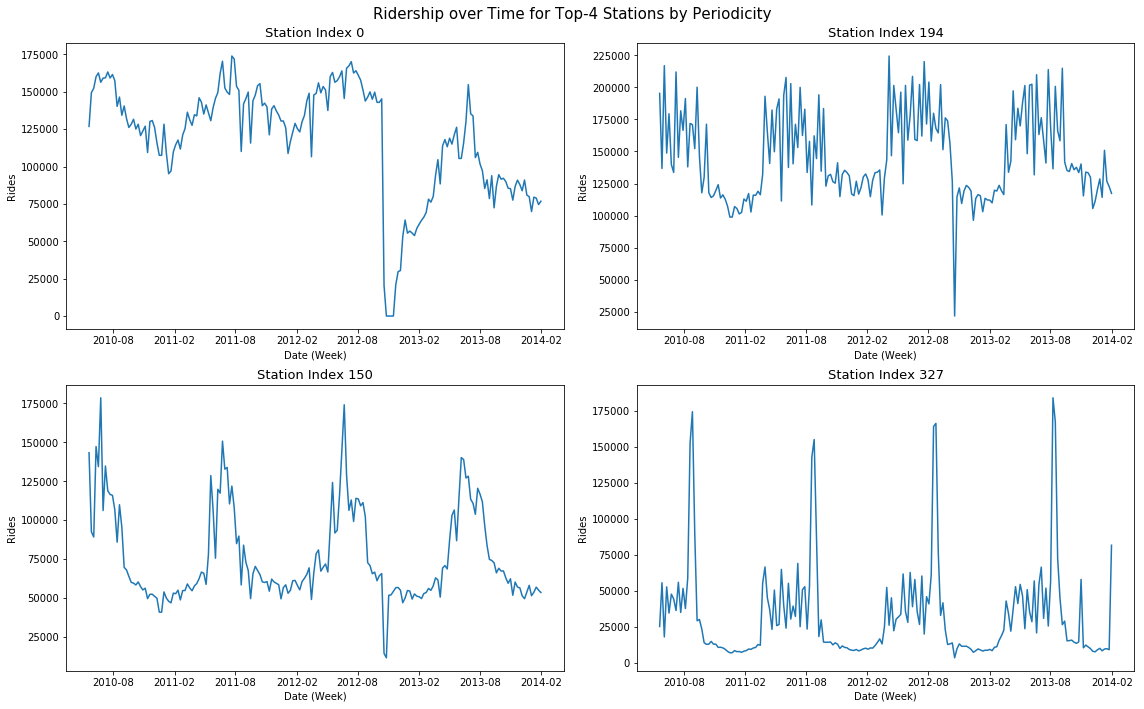

In [249]:
# Plot trends by top four
fig = plt.figure(figsize=(16,10))
fig.suptitle("Ridership over Time for Top-4 Stations by Periodicity", fontsize=15)
                 
for n, elem in enumerate(top_list):
    
    ax = fig.add_subplot(2,2,n+1)
    plt.plot(date_axis, stat_sum[elem])
    plt.xlabel('Date (Week)')
    plt.ylabel('Rides')
    plt.title('Station Index ' + str(elem), fontsize=13)
    
fig.tight_layout()
fig.subplots_adjust(top=0.93)

<b>Figure 7</b>: Top 4 stations by 52-week periodicity. All of the patterns correspond with summer activity. Stations 0, 150, and 194 seem to be from generically higher summertime activity (tourism, more events, better weather, etc.) and are probably in Manhattan at heavily used stations (http://graphics.wsj.com/table/NYRIDER_0420). Station 327 presents the most interesting pattern. It has generally higher summer activity, but there is a massive 2-week spike in activity in early August.

In [54]:
# Checking date
date_axis[np.where(stat_sum[327] == stat_sum[327].max())]

DatetimeIndex(['2013-08-09'], dtype='datetime64[ns]', freq=None)

Reviewed http://web.mta.info/developers/data/nyct/subway/Stations.csv - no match between station IDs there and here. Unsure offhand what the cause of the spike is. An annual event, conference, etc.?